# Imports and data

In [29]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import seaborn as sns
import utils.base_utils as bu
import utils.window_utils as wu
import numpy as np
start_date = '1971-09-30'
end_date = '2024-12-31'
# end_date = '2025-06-30' # kr and gsw end date
maturities = ['1'] + [str(i) for i in range(1, 121) if i % 12 == 0] # select only yearly maturities plus rf

yields = bu.get_yields(type='lw', start=start_date, end=end_date, maturities=maturities)
forward = bu.get_forward_rates(yields)
xr = bu.get_excess_returns(yields).dropna()
fred_md_raw = bu.get_fred_data('data/2026-01-MD.csv', start=start_date, end=end_date) # this is aligned to the last day of the previous month, so we get the same number of observations as the yields data

# At time t (end of month), we only know data for month t-1
fred_md = fred_md_raw.shift(1)  

# Drop dates outside the xr range
yields = yields.loc[yields.index <= xr.index[-1]]
forward = forward.loc[forward.index <= xr.index[-1]]
xr = xr.loc[xr.index <= xr.index[-1]]
fred_md = fred_md.loc[fred_md.index <= xr.index[-1]]

# Backfill fred_md to avoid nans
fred_md = fred_md.bfill()

In [25]:
import sklearn
import skglm

class LassoModel:
    def __init__(self, alpha=0.01):
        self.alpha = alpha

    def fit(self, X, y):
        self.model = sklearn.linear_model.Lasso(alpha=self.alpha)
        self.model.fit(X[['yields']], y)
    
    def predict(self, X):
        return self.model.predict(X[['yields']])
    
class GroupLassoModel:
    def __init__(self, alpha=0.01):
        self.alpha = alpha

    def fit(self, X, y):
        self.model = skglm.GroupLasso(alpha=self.alpha, groups=[10, 20, 30, 76])
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)

# Expanding window estimation

In [26]:
from models.base import *
from models.classical import *
from models.other import *
from models.ann import *
from models.gbt import *

OOS_start = pd.Timestamp('1989-01-31')

X = pd.concat([fred_md, forward, yields],
               axis=1,
               keys=['fred', 'forward', 'yields'])

y = xr['24'].values # 2-year excess returns
dates = xr.index

# Models to test
models = {
    # 'Lasso': LassoModel(alpha=0.00001),
    # 'Linear': LinearModel(),
    # 'PCA': PCABaselineModel(components=3),
    # 'GroupLasso': GroupLassoModel(alpha=0.01),
    # 'NN': GenericForwardRateANN()
    # 'RW': RandomWalkModel(),
    # 'Mean': HistoricalMeanModel()
    # 'CP': CochranePiazzesiModel(),
    'LN': LudvigsonNgModel(),
    # 'LN_BH': LudvigsonNgBauerHamiltonSpec()
    # 'XGB': XGBoostModel()
}

results = {}

for name, model in models.items():
    print(f"Running {name}...")
    y_forecast = wu.expanding_window(model, X, y, dates, OOS_start)
    r2 = wu.oos_r2(y, y_forecast)
    results[name] = {'forecast': y_forecast, 'R2_OOS': r2}
    print(f"  R2_OOS = {r2:.4f}")

# Summary
print("\n--- OOS R² Summary ---")
for name, res in results.items():
    print(f"  {name}: {res['R2_OOS']:.4f}")

Running LN...


Expanding window OOS: 100%|██████████| 420/420 [00:55<00:00,  7.51it/s]

  R2_OOS = -3.2498

--- OOS R² Summary ---
  LN: -3.2498


<Axes: xlabel='date'>

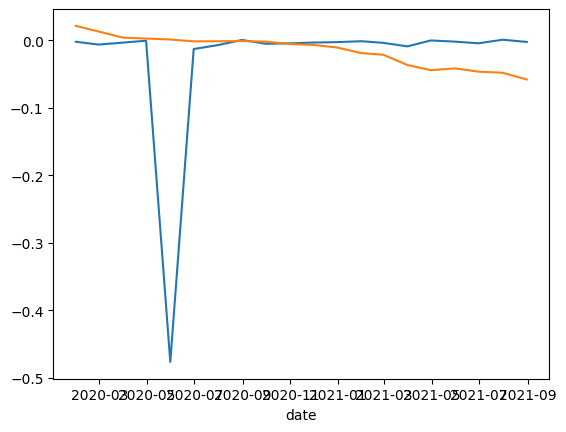

In [48]:
sns.lineplot(y=y_forecast[580:600], x=yields.index[580:600])
sns.lineplot(y=y[580:600], x=yields.index[580:600])

# Test in-sample fit

In [30]:
# full-sample R2 for comparison
y = xr['36'].values
model = LudvigsonNgBauerHamiltonSpec()
model.fit(X, y)
r2_full = sklearn.metrics.r2_score(y, model.predict(X))
r2_full

0.25135201750102454

<Axes: xlabel='date'>

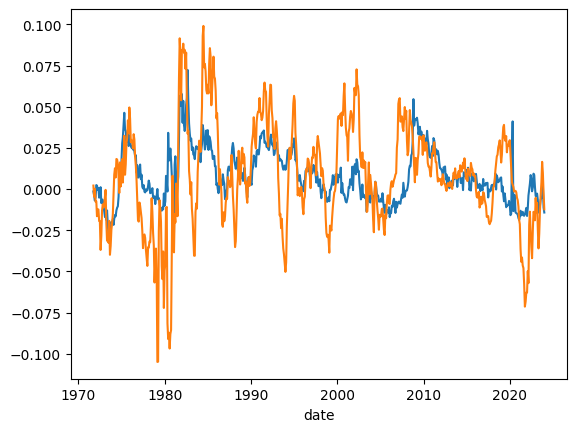

In [32]:
sns.lineplot(y=model.predict(X), x=yields.index)
sns.lineplot(y=y, x=yields.index)